In [399]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy

In [526]:
sig_c = 0.05      # bipolar receptive fied size ~ 1/5 of the actual size [mm]
tau1 = 0.04       # excitation time constant of the remporal filter [s]
tau2 = 0.0876     # rebound time constant [s]
bifw = 0.         # relative weight of rebound/excitation [1]
scale_mV = 20.    # UPDATED 

tauA = 0.15   # time constant of amacrine cells [s]
tauB = 0.08   # time constant of bipolar cells [s]
tauG = 0.01   # time contant of ganglion cells [s]

wAB = 10.     # synaptic weight from bipolar to amacrine [Hz]
wBA = -10.    # synaptic weight from amacrine to bipolar [Hz]
wGB = 4.0     # synaptic weight from bipolar to gangion  [Hz]  #UPDATED
wGA = 0.      # synaptic weight from amacrine  to gangion  [Hz]

slope = 5     # slope for ganglion cell recritifation [Hz/mV].   #UPDATED
threshold = 0 # threshold for ganglion cell recritifation [Hz/mV]

sig_pool = 0.065   # sigma for gaussian pooling in ganlion gells [mm]
spacing = 0.005    # spacing of cells on the lattice [mm]
delta = spacing 
N = 512             # number of neurons in each layer [1]
L =  N * delta      #300 * 0.005
idx = int(N/2)

b =  0.160          # half bar width [mm]
speed =  0.8        # speed [mm/s]
dt = 0.001          # integration time step [s]


import math
dur = L/speed                 # duration of the simulation [s]
tps = int(dur/dt)             # number of time-points in the simulation [1]
pow = np.floor(math.log2(tps))
dt = dur/2**pow


In [535]:
# load data
name = f'bar_{speed}'
net = 'recurrent_nn'
signal = np.load(f'output/{net}/BC_grid_{name}.npy')
stim = np.load(f'output/{net}/stim_{name}.npy')

In [536]:

def compute_spatiotemporal_frequencies(signal, dt, delta):

    # # Perform a 2D Fourier Transform on the signal
    ft_signal = np.fft.fft2(signal)

    # # Shift the zero frequency component to the center
    ft_signal= np.fft.fftshift(ft_signal)

    # # Compute the magnitude (for visualization)
    # magnitude_spectrum = np.abs(ft_signal_shifted)
    
    # Get the frequency components along each dimension
    spatial_freqs =np.fft.fftshift(np.fft.fftfreq(signal.shape[0], d=dt))
    temporal_freqs = np.fft.fftshift(np.fft.fftfreq(signal.shape[1], d = delta))

    # return spatial_freqs, temporal_freqs, magnitude_spectrum
    return spatial_freqs, temporal_freqs, ft_signal




def ghat(omega,k, v, L, s2 = -1):
    return 1j * (np.exp((-1j * (omega-k*v*s2) * (L/v)) -1) /(omega-k*v*s2) )


# def extract_resonance_speed(magnitudes): 
#     N,tps = magnitudes.shape
#     max_idx = magnitudes.argmax()
#     spacemax = max_idx // tps
#     timemax = max_idx % tps
#     return (spacemax*0.005)/(timemax*0.001) #mm/s


In [573]:
signal = signal - signal.mean(axis = 0)
stim = stim - stim.mean(axis = 0)
N, T = signal.shape
N, T


# #crop time such taht T is a power of 2
# import math
# pow = np.floor(math.log2(T))
# tps = int(2**pow)
# print(pow,tps)

# signal = signal[:,T-tps:]
# stim = stim[:,T-tps:]
# N,T = signal.shape




(512, 2048)

In [574]:
N,T,dt

(512, 2048, 0.0015624999999999999)

In [575]:
stim.shape

(512, 2048)

Text(0.0, 1.0, '$V_{B}$')

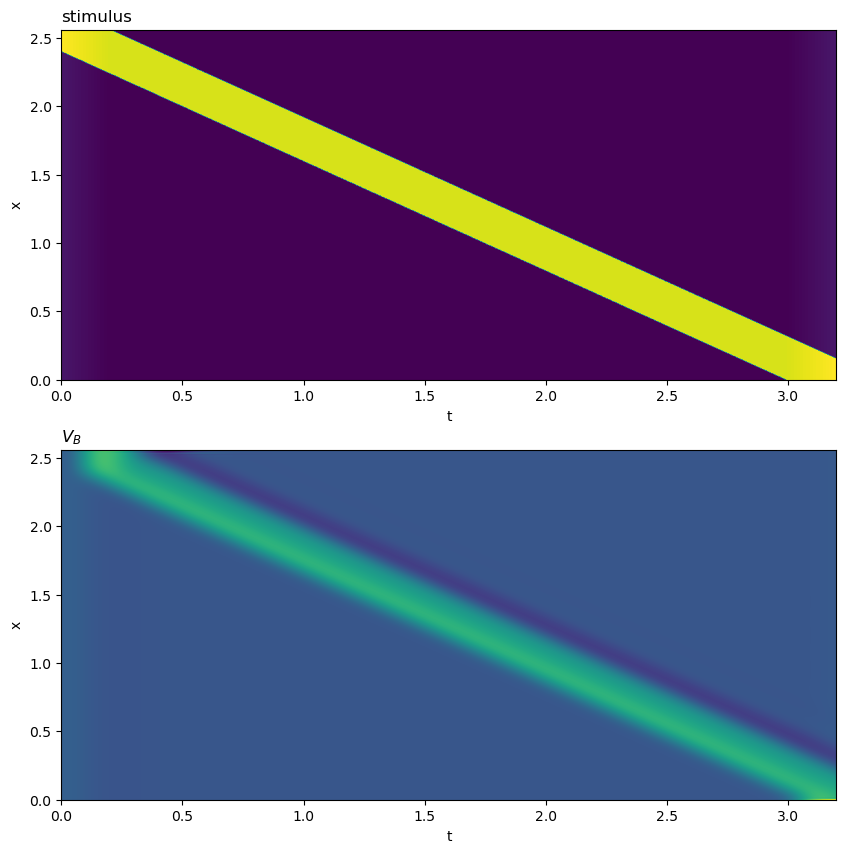

In [576]:
fig = plt.figure(figsize = (10,10))
gs = fig.add_gridspec(2,1)

ax = fig.add_subplot(gs[0,0])
ax.imshow(stim,extent=(0, T*dt, 0, L), aspect='auto')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('stimulus', loc = 'left')

ax = fig.add_subplot(gs[1,0])
ax.imshow(signal,extent=(0, T*dt, 0, L), aspect='auto')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title(r'$V_{B}$', loc = 'left')


In [578]:
# spatial_freqs, temporal_freqs, magnitude_spectrum = compute_spatiotemporal_frequencies(signal, dt = dt, delta = delta)
ks,omegas,fts = compute_spatiotemporal_frequencies(signal, dt = dt, delta = delta)
ks_s,omegas_s,fts_s = compute_spatiotemporal_frequencies(stim, dt = dt, delta = delta)

# omega_range = np.arange(-T/2, T/2, 1)
# k_range = np.arange(-N/2, N/2, 1)


domega = 1/(T*dt)   # resolution of fft
maxomega = (1/dt)/2 # maximal detectable frequency
omega_range = np.arange(-maxomega,maxomega,domega) # range of the output


dk = 1/(N*delta)
maxk = (1/delta)/2
k_range = np.arange(-maxk,maxk,dk)


t, x = np.meshgrid(omega_range, k_range)
# t = 1/(t/dt)
# x = 1/(x/spacing)
ghat_mat  =ghat(t,x,speed,L)


ftsdivghat = fts/ghat_mat
ftsdivbar = fts/fts_s


/var/folders/mz/v_y_dj556cs59qdf5qbn5tbc0000gn/T/ipykernel_18410/3164060695.py:23: RuntimeWarning: divide by zero encountered in divide
  return 1j * (np.exp((-1j * (omega-k*v*s2) * (L/v)) -1) /(omega-k*v*s2) )
/var/folders/mz/v_y_dj556cs59qdf5qbn5tbc0000gn/T/ipykernel_18410/3164060695.py:23: RuntimeWarning: invalid value encountered in divide
  return 1j * (np.exp((-1j * (omega-k*v*s2) * (L/v)) -1) /(omega-k*v*s2) )
/var/folders/mz/v_y_dj556cs59qdf5qbn5tbc0000gn/T/ipykernel_18410/3164060695.py:23: RuntimeWarning: invalid value encountered in multiply
  return 1j * (np.exp((-1j * (omega-k*v*s2) * (L/v)) -1) /(omega-k*v*s2) )
/var/folders/mz/v_y_dj556cs59qdf5qbn5tbc0000gn/T/ipykernel_18410/15414834.py:26: RuntimeWarning: divide by zero encountered in divide
  ftsdivbar = fts/fts_s
/var/folders/mz/v_y_dj556cs59qdf5qbn5tbc0000gn/T/ipykernel_18410/15414834.py:26: RuntimeWarning: invalid value encountered in divide
  ftsdivbar = fts/fts_s


In [579]:
print(f" signal dimensions ")
print(f" space points N = {N}, dn = {delta} s, L = {N*delta} s ")
print(f" time points T = {T},, dt = {dt} mm, D = {T*dt} mm ")
print("\n")
print(f" fft dimendions ")
print(f" space points K = {len(k_range)}, dk = {dk} [1/mm], max_k = {maxk} [1/mm] ")
print(f" time points O = {len(omega_range)}, do = {domega} [1/2], max_o = {maxomega} [1/s] ")



 signal dimensions 
 space points N = 512, dn = 0.005 s, L = 2.56 s 
 time points T = 2048,, dt = 0.0015624999999999999 mm, D = 3.1999999999999997 mm 


 fft dimendions 
 space points K = 512, dk = 0.390625 [1/mm], max_k = 100.0 [1/mm] 
 time points O = 2048, do = 0.3125 [1/2], max_o = 320.0 [1/s] 


In [580]:
maxomega/maxk # mm/s maximal detectable speed ?


3.2

Text(0.5, 1.0, 'spectrum / spectrum_stim')

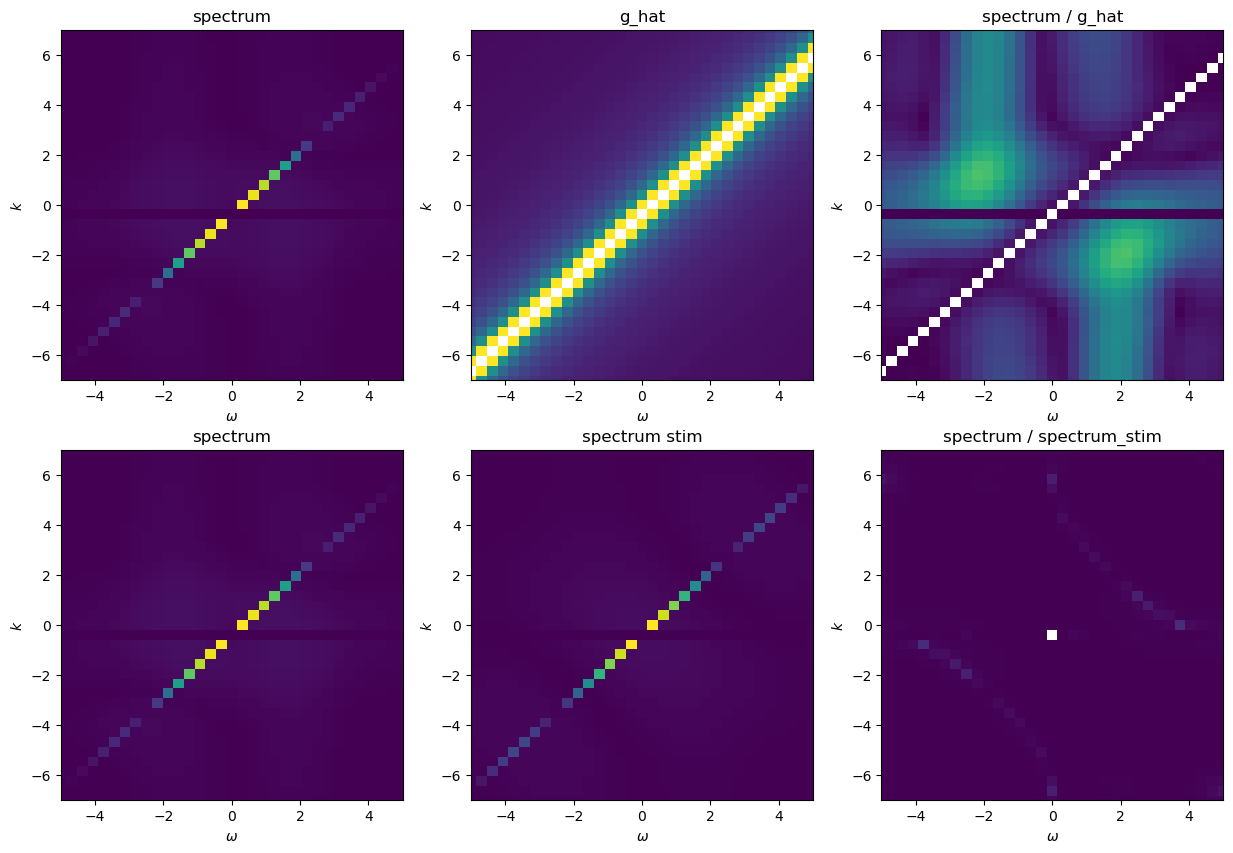

In [581]:
plot_extent = (omega_range[0], omega_range[-1], k_range[0], k_range[-1])
plot_xlim = (-5,5)
plot_ylim = (-7,7)

# plot_xlim = (omega_range[0], omega_range[-1])
# plot_ylim = (k_range[0], k_range[-1])


fig = plt.figure(figsize = (15,10))
gs = fig.add_gridspec(2,3)

ax = fig.add_subplot(gs[0,0])
ax.imshow(np.abs(fts),extent=plot_extent, aspect='auto')
ax.set_xlim(plot_xlim)
ax.set_ylim(plot_ylim)

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$k$')

ax.set_title('spectrum')

ax = fig.add_subplot(gs[0,1])
ax.imshow(np.abs(ghat_mat),extent=plot_extent, aspect='auto')
ax.set_xlim(plot_xlim)
ax.set_ylim(plot_ylim)
# ax.set_xlim(-1500,0)
# ax.set_ylim(-256,-100)

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$k$')

ax.set_title('g_hat')





ax = fig.add_subplot(gs[0,2])
ax.imshow(np.abs(ftsdivghat),extent=plot_extent, aspect='auto')
ax.set_xlim(plot_xlim)
ax.set_ylim(plot_ylim)

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$k$')

ax.set_title('spectrum / g_hat')





ax = fig.add_subplot(gs[1,0])
ax.imshow(np.abs(fts),extent=plot_extent, aspect='auto')
ax.set_xlim(plot_xlim)
ax.set_ylim(plot_ylim)

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$k$')

ax.set_title('spectrum')


ax = fig.add_subplot(gs[1,1])
ax.imshow(np.abs(fts_s),extent=plot_extent, aspect='auto')
ax.set_xlim(plot_xlim)
ax.set_ylim(plot_ylim)

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$k$')


ax.set_title('spectrum stim')




ax = fig.add_subplot(gs[1,2])
ax.imshow(np.abs(ftsdivbar),extent=plot_extent, aspect='auto')
ax.set_xlim(plot_xlim)
ax.set_ylim(plot_ylim)

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$k$')

ax.set_title('spectrum / spectrum_stim')





Text(0.5, 0, 'Z')

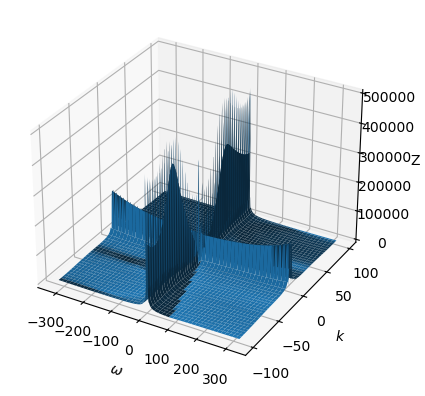

In [582]:
ax = plt.figure().add_subplot(projection='3d')

# plot spectrum
ax.plot_surface(t,x, np.abs(ftsdivghat))

# Make legend, set axes limits and labels
# ax.set_zlim(0, 1000)
# ax.set_xlim(plot_xlim)
# ax.set_ylim(plot_ylim)
ax.set_xlabel(r'$\omega$')
ax.set_ylabel('$k$')
ax.set_zlabel('Z')


